In [31]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os
import requests  
import pyspark as ps
import re
import math
from scipy import stats
from pyspark.sql.functions import udf, concat, col, lit
from numpy.core.fromnumeric import shape
from pyspark.sql.types import *
from pyspark.sql import functions as f

In [36]:
plt.style.use("ggplot")
plt.style.use("dark_background")

In [2]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
yourpath = './COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'

dict = {}
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        dict[name[:-4]]= pd.read_csv(yourpath+name)

In [4]:
pop_density= pd.read_csv('./Population-Density_By_State.csv', delimiter=',')  
pop_density.rename(columns={'GEO.display-label':'States'}, inplace=True)
pop_density.drop(columns=['GEO.id','GEO.id2'], axis=1, inplace=True)
pop_density.drop(index=[51],axis=0, inplace=True)

In [5]:
dc =pd.Series({'state_name':'District of Columbia','party':'democrat','name':'Muriel Bowser'})
governor= pd.read_csv('./us-governors.csv', delimiter=',')
pop_density.rename(columns={'state_name':'States'}, inplace=True)
governor.drop(columns=['state_name_slug','state_code','state_code_slug','votesmart','title','name_slug','first_name','middle_name','last_name','name_suffix','goes_by','pronunciation','gender','ethnicity','religion','openly_lgbtq','date_of_birth','entered_office','term_end','biography','phone','fax','latitude','longitude','address_complete','address_number','address_prefix','address_street','address_sec_unit_type','address_sec_unit_num','address_city','address_state','address_zipcode','address_type','website','contact_page','facebook_url','twitter_handle','twitter_url','photo_url'], axis=1, inplace=True)
poli_leader = governor.append(dc,ignore_index=True)
poli_leader = poli_leader.sort_values(by=['state_name'])

In [6]:
popu= pd.read_csv('./popstate.csv', delimiter='\t')

In [7]:
city_pop = pd.read_csv('./PopbyCIty.csv', engine='python', delimiter='\t')

In [8]:
citypop = spark.read.options(header='True', inferSchema='True', delimiter='\t').csv('./popcity.csv')
citypop.createOrReplaceTempView('cp')
commaRep = udf(lambda x: re.sub(',','', x))
test=citypop.select('2020rank',col("estimate").alias('estimate'))
test=test.withColumn('estimate',commaRep('estimate'))
test=test.withColumn("estimate",test.estimate.cast(IntegerType()))

In [9]:
c1 = spark.sql('SELECT State as States, COUNT(State) as Cities_100 FROM cp GROUP BY State ORDER BY State')
cit_100 = c1.toPandas()
ss =pd.DataFrame({'States':[' West Virginia',' Maine',' Vermont', ' Wyoming',' Delaware'], 'Cities_100':[0,0,0,0,0]})
cit_100 = cit_100.append(ss,ignore_index=True)
cit_100 = cit_100.sort_values(by=['States'])

In [10]:
cit_500= spark.sql('SELECT State, COUNT(State) as Count FROM cp WHERE estimate>500000 GROUP BY State ORDER BY State')

In [11]:
twentyone={}
twenty = {}

for k,v in dict.items():
    if k[-1]=='1':
        
        twentyone[k]=v
    else:
        twenty[k]=v     

In [12]:
df = pd.DataFrame()
for k,v in sorted(twenty.items()):
    df['States']= v['Province_State']
    df['Lat']= v['Lat']
    df['Long']= v['Long_']
    break
df.sort_values(by='States')
df.drop(index=[2,9,13,14,39,44,52,58], inplace=True)

In [13]:
new_df= df.merge(pop_density['Density per square mile of land area'], on=pop_density['States'], how='left')
new_df.drop(columns='key_0', inplace=True)
new_df1= new_df.merge(poli_leader['party'], on=pop_density['States'], how='left')
new_df1.drop(columns='key_0', inplace=True)
new_df2= new_df1.merge(cit_100['Cities_100'], on=pop_density['States'], how='inner')
new_df2.drop(columns='key_0', inplace=True)
new_df3= new_df2.merge(popu['Pop_2019'], on=pop_density['States'], how='inner')
new_df3.drop(columns='key_0', inplace=True)

In [14]:
for k,v in sorted(twenty.items()):
    v.sort_values(by='Province_State')
    v.drop(index=[2,9,13,14,39,44,52], inplace=True)
    v.index=range(0,len(v))
for k,v in sorted(twentyone.items()):
    v.sort_values(by='Province_State')
    v.drop(index=[2,9,13,14,39,44,52], inplace=True)
    v.index=range(0,len(v))

In [15]:
for k,v in sorted(twenty.items()):
    #lst.append(v['Confirmed'])
    #lst.append(v['Deaths'])
    new_df3[k + ' confirmed'] = v['Confirmed']
    new_df3[k + ' deaths'] = v['Deaths']

for k,v in sorted(twentyone.items()):
    new_df3[k + ' confirmed'] = v['Confirmed']
    new_df3[k + ' deaths'] = v['Deaths']

In [16]:
confirmed_cases=new_df3.iloc[:,7::2]
confirmed_deaths=new_df3.iloc[:,8::2]

In [23]:
confirmed_death_total=new_df3.iloc[:,-1]
confirmed_cases_total=new_df3.iloc[:,-2]
new_df3['cd_percentage'] = confirmed_death_total/new_df3['Pop_2019']
new_df3['cc_percentage'] = confirmed_cases_total/new_df3['Pop_2019']

In [18]:
rep_idx = new_df3[new_df3['party']=='republican'].index
dem_idx = new_df3[new_df3['party']!='republican'].index

In [34]:
dens1_idx = new_df3[new_df3['Density per square mile of land area']<=100].index
dens100_idx = new_df3[new_df3['Density per square mile of land area']>=100].index

In [ ]:
rep = confirmed_cases.T.pct_change()

In [59]:
new_df3

States      Lat      Long  \
0                Alabama  32.3182  -86.9023   
1                 Alaska  61.3707 -152.4044   
2                Arizona  33.7298 -111.4312   
3               Arkansas  34.9697  -92.3731   
4             California  36.1162 -119.6816   
5               Colorado  39.0598 -105.3111   
6            Connecticut  41.5978  -72.7554   
7               Delaware  39.3185  -75.5071   
8   District of Columbia  38.8974  -77.0268   
9                Florida  27.7663  -81.6868   
10               Georgia  33.0406  -83.6431   
11                Hawaii  21.0943 -157.4983   
12                 Idaho  44.2405 -114.4788   
13              Illinois  40.3495  -88.9861   
14               Indiana  39.8494  -86.2583   
15                  Iowa  42.0115  -93.2105   
16                Kansas  38.5266  -96.7265   
17              Kentucky  37.6681  -84.6701   
18             Louisiana  31.1695  -91.8678   
19                 Maine  44.6939  -69.3819   
20              Maryland  39.0639  -76.8021   
21         Massachusetts  42.2302  -71.5301   
22              Michigan  43.3266  -84.5361   
23             Minnesota  45.6945  -93.9002   
24           Mississippi  32.7416  -89.6787   
25              Missouri  38.4561  -92.2884   
26               Montana  46.9219 -110.4544   
27              Nebraska  41.1254  -98.2681   
28                Nevada  38.3135 -117.0554   
29         New Hampshire  43.4525  -71.5639   
30            New Jersey  40.2989  -74.5210   
31            New Mexico  34.8405 -106.2485   
32              New York  42.1657  -74.9481   
33        North Carolina  35.6301  -79.8064   
34          North Dakota  47.5289  -99.7840   
35                  Ohio  40.3888  -82.7649   
36              Oklahoma  35.5653  -96.9289   
37                Oregon  44.5720 -122.0709   
38          Pennsylvania  40.5908  -77.2098   
39          Rhode Island  41.6809  -71.5118   
40        South Carolina  33.8569  -80.9450   
41          South Dakota  44.2998  -99.4388   
42             Tennessee  35.7478  -86.6923   
43                 Texas  31.0545  -97.5635   
44                  Utah  40.1500 -111.8624   
45               Vermont  44.0459  -72.7107   
46              Virginia  37.7693  -78.1700   
47            Washington  47.4009 -121.4905   
48         West Virginia  38.4912  -80.9545   
49             Wisconsin  44.2685  -89.6165   
50               Wyoming  42.7560 -107.3025   

    Density per square mile of land area       party  Cities_100  Pop_2019  \
0                                   94.4  republican           5   4903185   
1                                    1.2  republican           1    731545   
2                                   56.3  republican          10   7278717   
3                                   56.0  republican           1   3017804   
4                                  239.1    democrat          75  39512223   
5                                   48.5    democrat          12   5758736   
6                                  738.1    democrat           5   3565287   
7                                  460.8    democrat           0    973764   
8                                 9856.5    democrat           1    705749   
9                                  350.6  republican          22  21477737   
10                                 168.4  republican           8  10617423   
11                                 211.8    democrat           1   1415872   
12                                  19.0  republican           3   1787065   
13                                 231.1    democrat           8  12671821   
14                                 181.0  republican           5   6732219   
15                                  54.5  republican           3   3155070   
16                                  34.9    democrat           5   2913314   
17                                 109.9    democrat           2   4467673   
18                                 104.9    democrat           4   4648794   
19           

In [29]:
rep_c = confirmed_cases.T.pct_change().mean()[rep_idx]
dem_c= confirmed_cases.T.pct_change().mean()[dem_idx]
stats.ttest_ind(rep_c,dem_c)

Ttest_indResult(statistic=2.6776306026671195, pvalue=0.01006048059985417)

In [28]:
rep_d = confirmed_deaths.T.pct_change().mean()[rep_idx]
dem_d = confirmed_deaths.T.pct_change().mean()[dem_idx]
stats.ttest_ind(rep_d,dem_d)

Ttest_indResult(statistic=3.0884191037100033, pvalue=0.0033102423353301765)

In [42]:
below_c = confirmed_deaths.T.pct_change().mean()[dens1_idx ]
over_c = confirmed_deaths.T.pct_change().mean()[dens100_idx]
stats.ttest_ind(below_c,over_c)

Ttest_indResult(statistic=4.292505369372853, pvalue=8.309748103503926e-05)

In [41]:
below_d = confirmed_deaths.T.pct_change().mean()[dens1_idx ]
over_d = confirmed_deaths.T.pct_change().mean()[dens100_idx]
stats.ttest_ind(below_d,over_d)

Ttest_indResult(statistic=4.292505369372853, pvalue=8.309748103503926e-05)

In [ ]:
final_df = pd.read_csv('/home/aa1/Covid-cause-and-effect/Final_df.csv')
confirmed_cases=final_df.iloc[:,8::2]
confirmed_deaths=final_df.iloc[:,9::2]

In [ ]:
ct = confirmed_cases.T
df1 = pd.Series(final_df['States'])
ct.columns=df1

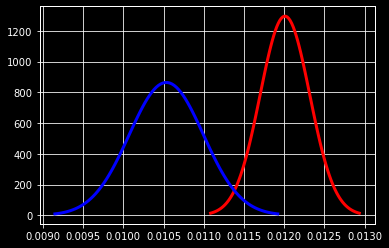

In [40]:
fig, ax = plt.subplots()
mu = rep_c.mean()
sigma = math.sqrt(rep_c.var())
se = sigma/math.sqrt(len(rep_c))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='red',label='Republican',lw=3)
mu = dem_c.mean()
sigma = math.sqrt(dem_c.var())
se = sigma/math.sqrt(len(dem_c))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='blue',label='Republican',lw=3)

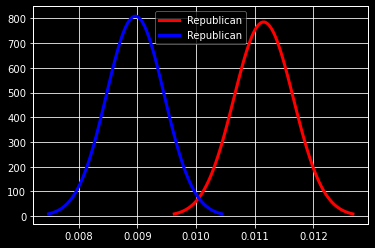

In [48]:
fig, ax = plt.subplots()
mu = rep_d.mean()
sigma = math.sqrt(rep_d.var())
se = sigma/math.sqrt(len(rep_d))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='red',label='Republican',lw=3)
mu = dem_d.mean()
sigma = math.sqrt(dem_d.var())
se = sigma/math.sqrt(len(dem_d))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='blue',label='Republican',lw=3)
ax.legend()

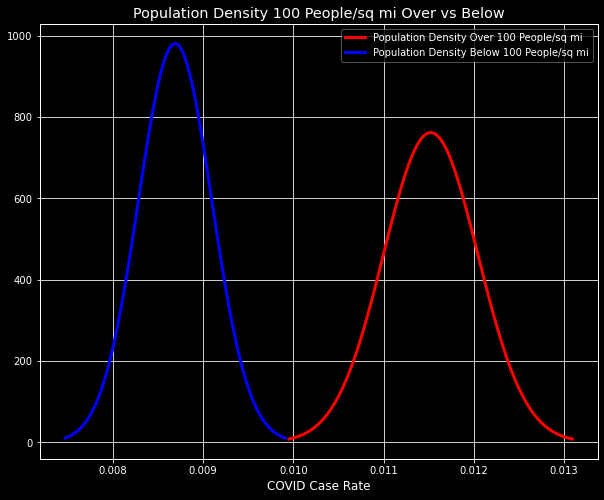

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
mu = below_c.mean()
sigma = math.sqrt(below_c.var())
se = sigma/math.sqrt(len(below_c))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='red',label='Population Density Over 100 People/sq mi',lw=3)
mu = over_c.mean()
sigma = math.sqrt(over_c.var())
se = sigma/math.sqrt(len(over_c))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='blue',label='Population Density Below 100 People/sq mi',lw=3)
ax.legend()
ax.set_xlabel('COVID Case Rate')
ax.set_title('Population Density 100 People/sq mi Over vs Below')
fig.savefig('./PopulationDensity100PeoplesqmiOvervsBelow.png')

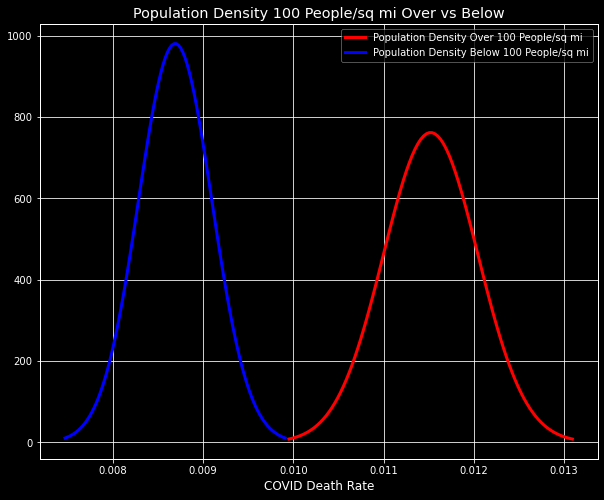

In [66]:
fig, ax = plt.subplots(figsize=(10,8))
mu = below_d.mean()
sigma = math.sqrt(below_d.var())
se = sigma/math.sqrt(len(below_d))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='red',label='Population Density Over 100 People/sq mi',lw=3)
mu = over_c.mean()
sigma = math.sqrt(over_d.var())
se = sigma/math.sqrt(len(over_d))
x = np.linspace(mu - 3*se, mu + 3*se, 100)
ax.plot(x, stats.norm.pdf(x, mu, se),color='blue',label='Population Density Below 100 People/sq mi',lw=3)
ax.legend()
ax.set_xlabel('COVID Death Rate')
ax.set_title('Population Density 100 People/sq mi Over vs Below')
fig.savefig('./PopulationDensity100PeoplesqmiOvervsBelowDeaths.png')